   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

Saving 2d input.mp4 to 2d input.mp4


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Processing frames:   0%|          | 0/315 [00:00<?, ?it/s]

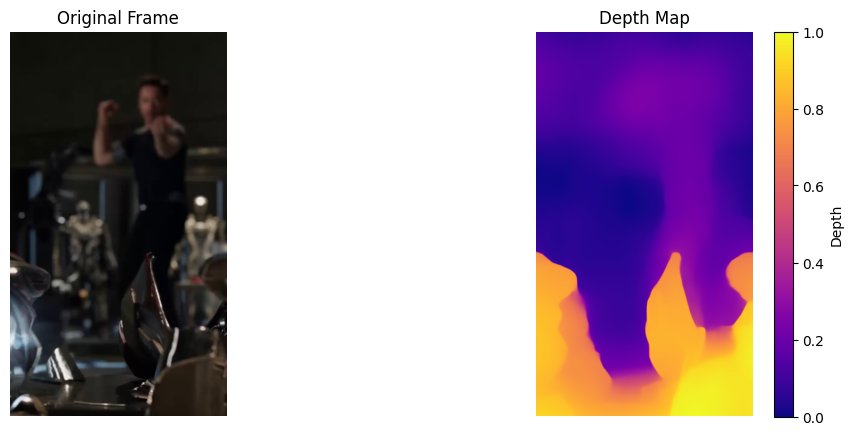

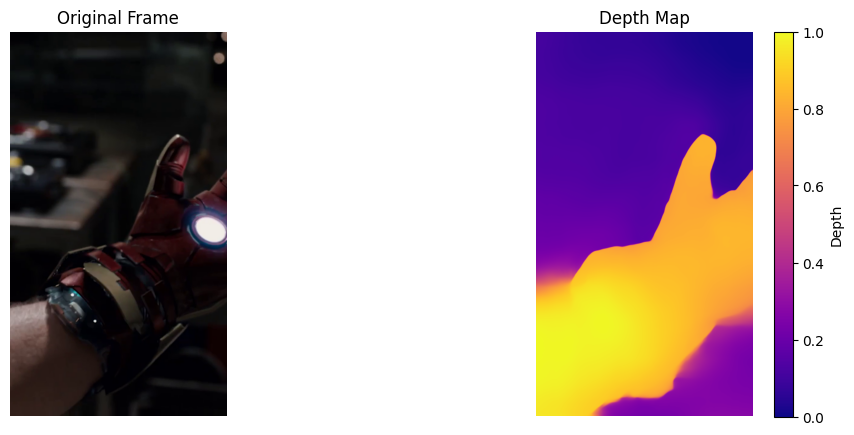

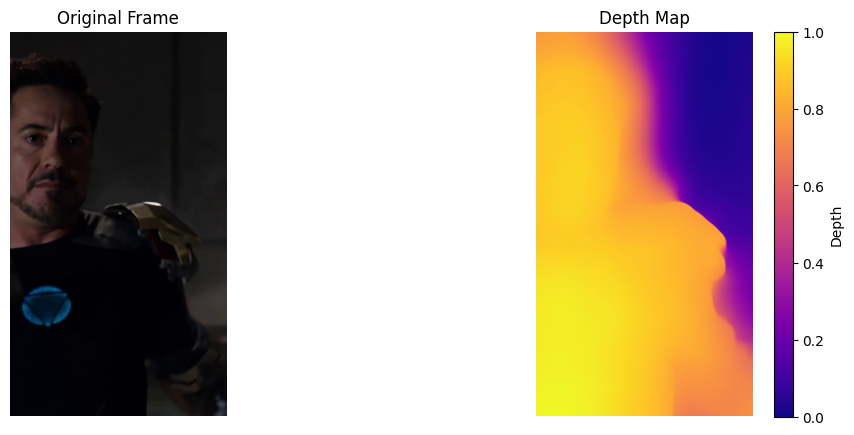

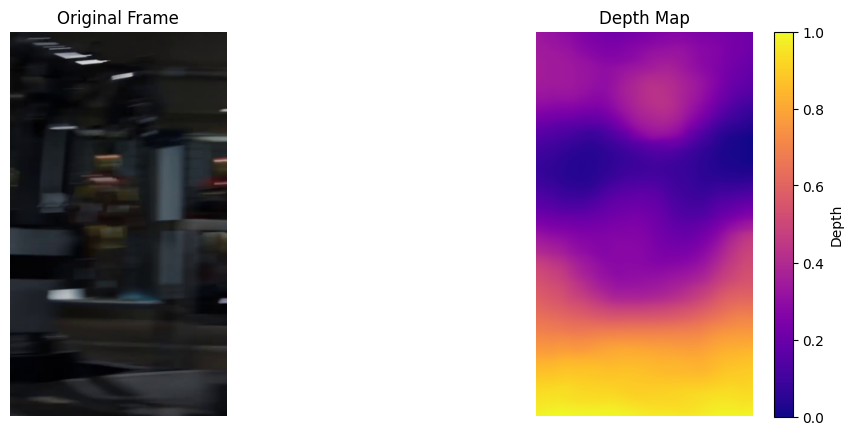

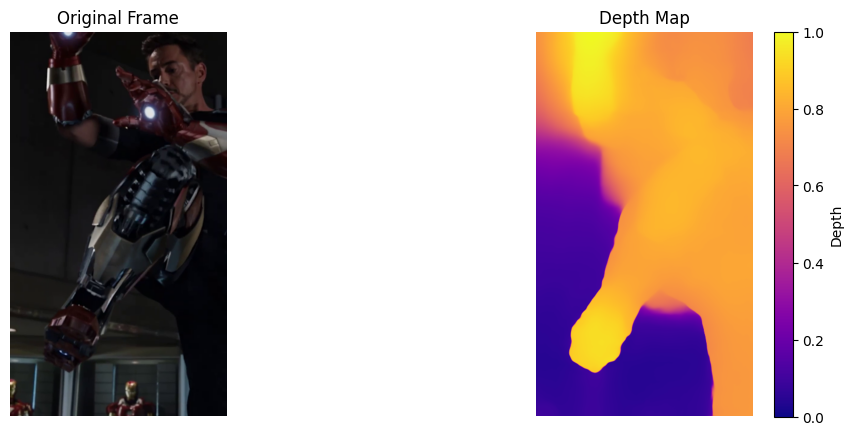

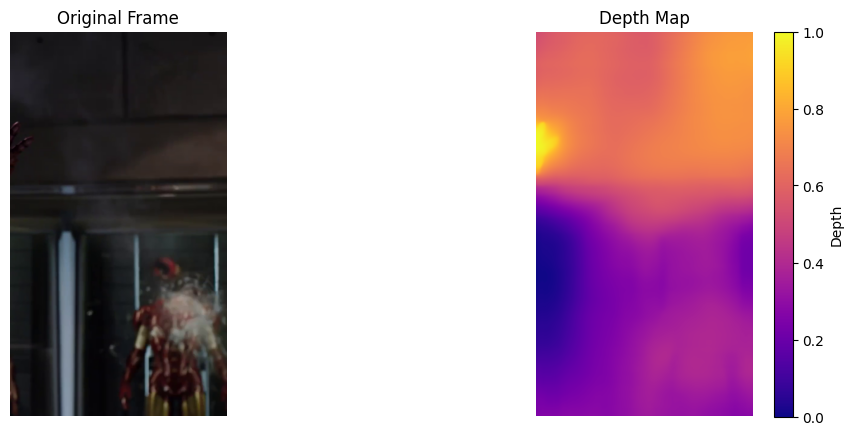

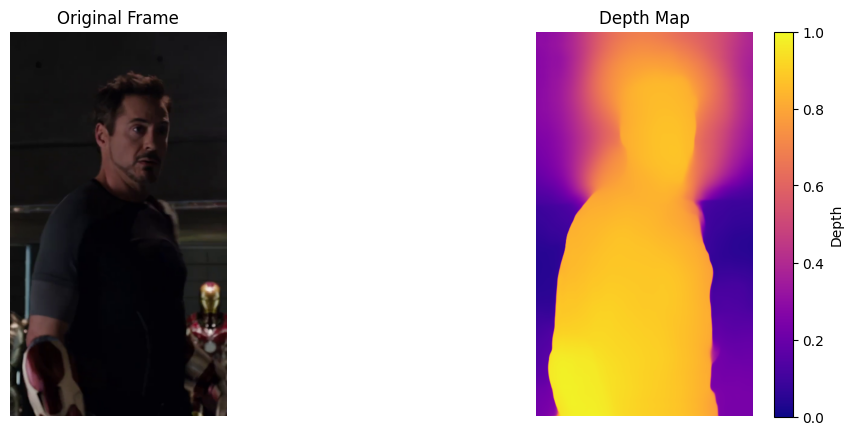

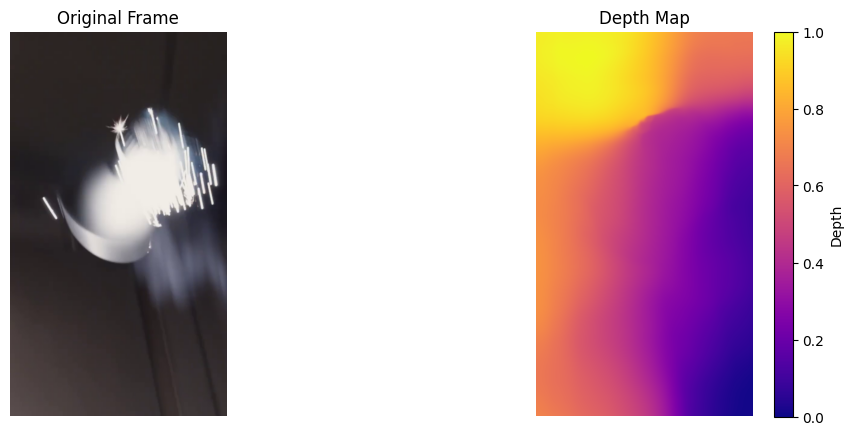

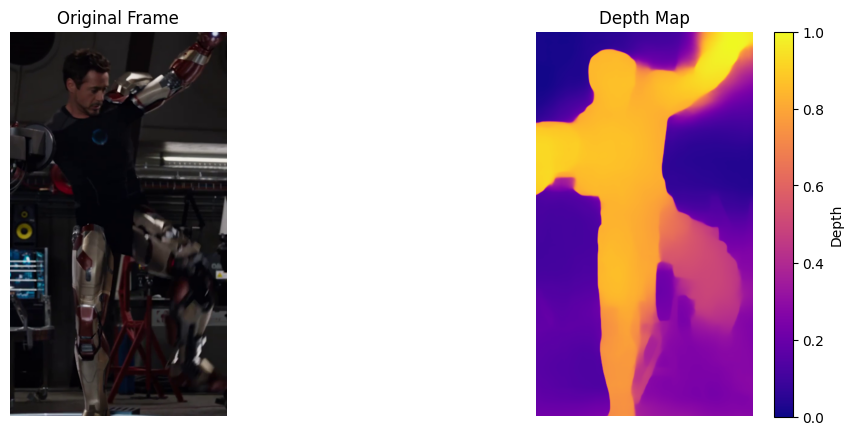

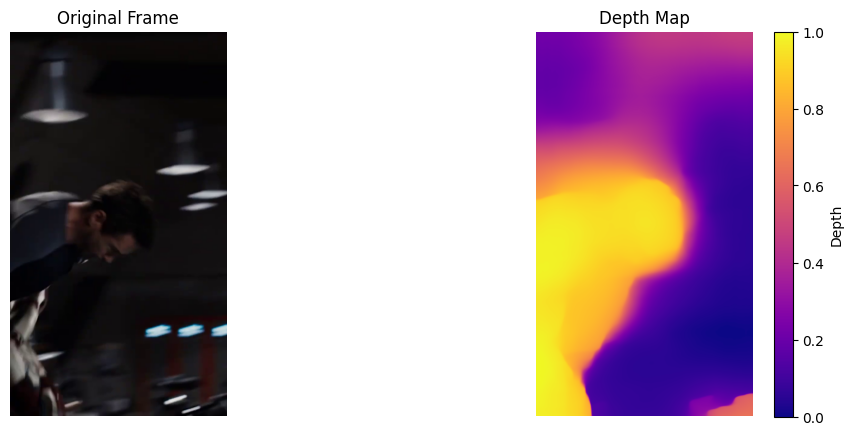

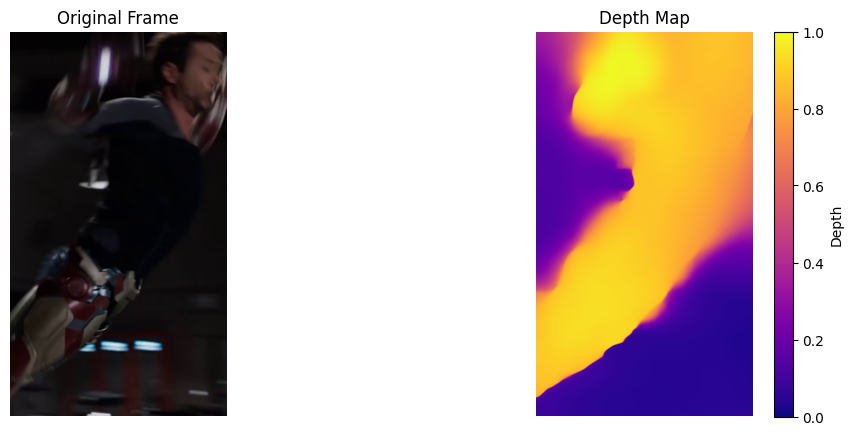


Video processing complete!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing complete! You can now download the depth map video.


In [ ]:
# Install required packages
!pip install opencv-python-headless
!pip install torch torchvision timm
!pip install matplotlib

import cv2
import torch
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io
from tqdm.notebook import tqdm

print("Setup complete!")

# Upload the video file
uploaded = files.upload()
video_path = next(iter(uploaded))

# Load MiDaS model
midas_model_type = "DPT_Large"
midas_model = torch.hub.load("intel-isl/MiDaS", midas_model_type)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas_model.to(device)
midas_model.eval()

# Load transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

def preprocess_frame(frame):
    # Apply color correction
    result = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    color_corrected = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

    # Apply noise reduction
    denoised = cv2.fastNlMeansDenoisingColored(color_corrected, None, 10, 10, 7, 21)

    return denoised

def estimate_depth(frame):
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Prepare frame for depth estimation
    input_batch = transform(frame_rgb).to(device)

    # Compute depth
    with torch.no_grad():
        prediction = midas_model(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()

    # Normalize depth map
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)

    return normalized_depth

def create_depth_video(video_path, output_path='depth_output.mp4', save_interval=30):
    # Open video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height), False)

    # Process frames with progress bar
    with tqdm(total=total_frames, desc="Processing frames") as pbar:
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Preprocess frame
            processed_frame = preprocess_frame(frame)

            # Estimate depth
            depth_map = estimate_depth(processed_frame)

            # Convert depth map for video writing
            depth_frame = (depth_map * 255).astype(np.uint8)

            # Write frame
            out.write(depth_frame)

            # Display sample frames
            if frame_count % save_interval == 0:
                plt.figure(figsize=(12, 5))
                plt.subplot(121)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title('Original Frame')
                plt.axis('off')

                plt.subplot(122)
                plt.imshow(depth_map, cmap='plasma')
                plt.title('Depth Map')
                plt.colorbar(label='Depth')
                plt.axis('off')
                plt.show()

            frame_count += 1
            pbar.update(1)

    # Release resources
    cap.release()
    out.release()
    print("\nVideo processing complete!")

    return output_path

# Process video and generate depth maps
output_video = create_depth_video(video_path)

# Download the processed video
files.download(output_video)

print("Processing complete! You can now download the depth map video.")


Creating anaglyph video:   0%|          | 0/157 [00:00<?, ?it/s]

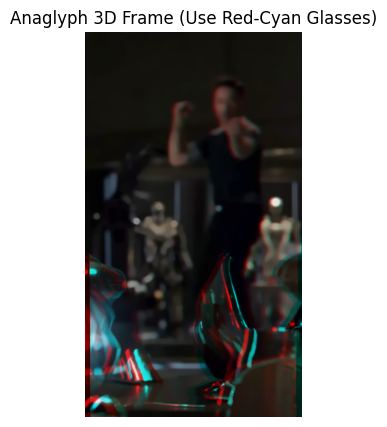

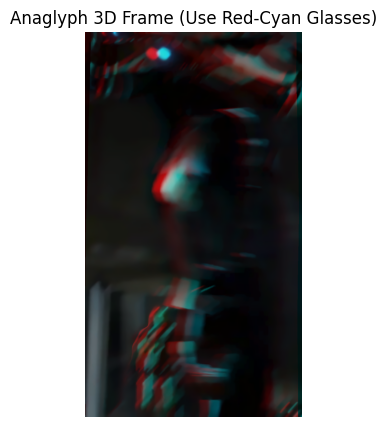

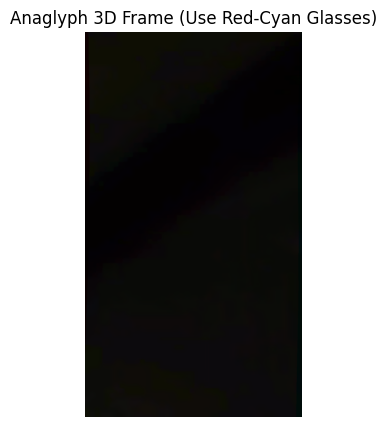

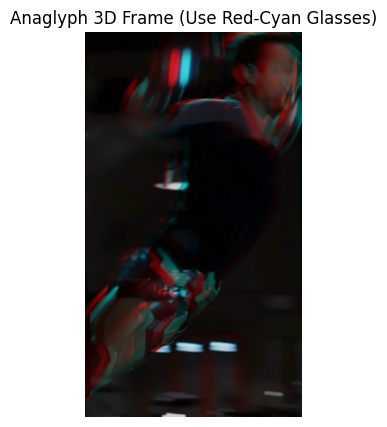


Anaglyph video processing complete!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def create_anaglyph_frame(rgb_frame, depth_map, strength=20):
    """Create anaglyph (red-cyan) 3D frame from RGB and depth."""
    # Convert depth map to disparity
    disparity = (depth_map * strength).astype(np.float32)

    height, width = rgb_frame.shape[:2]

    # Create left and right images
    left_image = np.zeros_like(rgb_frame)
    right_image = np.zeros_like(rgb_frame)

    for y in range(height):
        for x in range(width):
            # Calculate offset based on depth
            offset = int(disparity[y, x])

            # Left image (red channel)
            if x + offset < width:
                left_image[y, x] = rgb_frame[y, x + offset]

            # Right image (cyan channels)
            if x - offset >= 0:
                right_image[y, x] = rgb_frame[y, x - offset]

    # Create anaglyph image
    anaglyph = np.zeros_like(rgb_frame)
    anaglyph[:, :, 0] = left_image[:, :, 0]   # Red channel
    anaglyph[:, :, 1] = right_image[:, :, 1]  # Green channel
    anaglyph[:, :, 2] = right_image[:, :, 2]  # Blue channel

    return anaglyph

def process_video_to_anaglyph(video_path, output_path='anaglyph_output.mp4',
                              max_frames=1800, frame_step=2, strength=20):
    """Process video to anaglyph 3D."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_process = min(total_frames, max_frames)

    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps // frame_step, (frame_width, frame_height), True)

    frame_count = 0
    processed_count = 0

    try:
        with tqdm(total=frames_to_process // frame_step,
                  desc="Creating anaglyph video") as pbar:
            while cap.isOpened() and processed_count < max_frames:
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % frame_step == 0:
                    # Preprocess frame
                    processed_frame = preprocess_frame(frame)
                    depth_map = estimate_depth(processed_frame)

                    # Create anaglyph frame
                    anaglyph = create_anaglyph_frame(
                        cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB),
                        depth_map,
                        strength=strength
                    )

                    # Write frame
                    out.write(cv2.cvtColor(anaglyph, cv2.COLOR_RGB2BGR))

                    # Display sample frames
                    if processed_count % 50 == 0:
                        plt.figure(figsize=(15, 5))
                        plt.imshow(anaglyph)
                        plt.title('Anaglyph 3D Frame (Use Red-Cyan Glasses)')
                        plt.axis('off')
                        plt.show()

                    processed_count += 1
                    pbar.update(1)

                frame_count += 1

    finally:
        cap.release()
        out.release()

    print("\nAnaglyph video processing complete!")
    files.download(output_path)

# Example usage:
# Adjust parameters as needed
MAX_FRAMES = 1800  # Process up to 1 minute of video at 30 FPS
FRAME_STEP = 2     # Process every other frame
STRENGTH = 20      # Depth strength for the 3D effect

process_video_to_anaglyph(video_path,
                          max_frames=MAX_FRAMES,
                          frame_step=FRAME_STEP,
                          strength=STRENGTH)


In [ ]:
# Install required packages
!pip install opencv-python-headless
!pip install torch torchvision timm
!pip install matplotlib

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tqdm.notebook import tqdm

print("Setup complete!")

# Upload the video file
uploaded = files.upload()
video_path = next(iter(uploaded))

# Load MiDaS model
midas_model_type = "DPT_Large"
midas_model = torch.hub.load("intel-isl/MiDaS", midas_model_type)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas_model.to(device)
midas_model.eval()

# Load transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

def preprocess_frame(frame):
    """Apply preprocessing to a single frame."""
    # Apply color correction
    result = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    color_corrected = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)

    # Apply noise reduction
    denoised = cv2.fastNlMeansDenoisingColored(color_corrected, None, 10, 10, 7, 21)

    return denoised

def estimate_depth(frame):
    """Estimate depth map for a single frame."""
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Prepare frame for depth estimation
    input_batch = transform(frame_rgb).to(device)

    # Compute depth
    with torch.no_grad():
        prediction = midas_model(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()

    # Normalize depth map
    depth_min = depth_map.min()
    depth_max = depth_map.max()
    normalized_depth = (depth_map - depth_min) / (depth_max - depth_min)

    return normalized_depth

def create_anaglyph_frame(rgb_frame, depth_map, strength=20):
    """Create anaglyph (red-cyan) 3D frame from RGB and depth."""
    # Convert depth map to disparity
    disparity = (depth_map * strength).astype(np.float32)

    height, width = rgb_frame.shape[:2]

    # Create left and right images
    left_image = np.zeros_like(rgb_frame)
    right_image = np.zeros_like(rgb_frame)

    for y in range(height):
        for x in range(width):
            # Calculate offset based on depth
            offset = int(disparity[y, x])

            # Left image (red channel)
            if x + offset < width:
                left_image[y, x] = rgb_frame[y, x + offset]

            # Right image (cyan channels)
            if x - offset >= 0:
                right_image[y, x] = rgb_frame[y, x - offset]

    # Create anaglyph image
    anaglyph = np.zeros_like(rgb_frame)
    anaglyph[:, :, 0] = left_image[:, :, 0]   # Red channel
    anaglyph[:, :, 1] = right_image[:, :, 1]  # Green channel
    anaglyph[:, :, 2] = right_image[:, :, 2]  # Blue channel

    return anaglyph

def process_video(video_path, depth_output='depth_output.mp4', anaglyph_output='anaglyph_output.mp4',
                  max_frames=1800, frame_step=2, strength=20):
    """Process video to create depth map video and anaglyph 3D video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_process = min(total_frames, max_frames)

    # Create video writers
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    depth_writer = cv2.VideoWriter(depth_output, fourcc, fps // frame_step, (frame_width, frame_height), False)
    anaglyph_writer = cv2.VideoWriter(anaglyph_output, fourcc, fps // frame_step, (frame_width, frame_height), True)

    frame_count = 0
    processed_count = 0

    try:
        with tqdm(total=frames_to_process // frame_step, desc="Processing video") as pbar:
            while cap.isOpened() and processed_count < max_frames:
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % frame_step == 0:
                    # Preprocess frame
                    processed_frame = preprocess_frame(frame)
                    depth_map = estimate_depth(processed_frame)

                    # Write depth map frame
                    depth_frame = (depth_map * 255).astype(np.uint8)
                    depth_writer.write(depth_frame)

                    # Create and write anaglyph frame
                    anaglyph = create_anaglyph_frame(
                        cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB),
                        depth_map,
                        strength=strength
                    )
                    anaglyph_writer.write(cv2.cvtColor(anaglyph, cv2.COLOR_RGB2BGR))

                    # Display sample frames
                    if processed_count % 50 == 0:
                        plt.figure(figsize=(15, 5))
                        plt.subplot(121)
                        plt.imshow(depth_map, cmap='plasma')
                        plt.title('Depth Map')
                        plt.colorbar(label='Depth')
                        plt.axis('off')

                        plt.subplot(122)
                        plt.imshow(anaglyph)
                        plt.title('Anaglyph Frame (Use Red-Cyan Glasses)')
                        plt.axis('off')

                        plt.show()

                    processed_count += 1
                    pbar.update(1)

                frame_count += 1

    finally:
        cap.release()
        depth_writer.release()
        anaglyph_writer.release()

    print("\nVideo processing complete!")
    print("Downloading Depth Map Video...")
    files.download(depth_output)
    print("Downloading Anaglyph 3D Video...")
    files.download(anaglyph_output)

# Process video to create both outputs
process_video(video_path)
